In [1]:
#Bayesian Scan test example

|   iter    |  target   |     i     |     j     |
-------------------------------------------------
| 1         | 0.0       | 363.30391 | 922.19287 |
| 2         | 0.0       | 710.03412 | 580.69872 |
| 3         | 0.0       | 151.33808 | 151.31468 |
| 4         | 277.0     | 56.341103 | 840.19086 |
| 5         | 0.0       | 583.08156 | 686.83040 |
| 6         | 0.0       | 19.966959 | 940.81255 |
| 7         | 0.0       | 807.46936 | 205.96893 |
| 8         | 0.0       | 176.37021 | 177.90237 |
| 9         | 0.0       | 295.11497 | 509.01373 |
| 10        | 0.0       | 418.98666 | 282.49226 |
| 11        | 183.0     | 66.288200 | 812.59307 |
| 12        | 277.0     | 56.412710 | 840.88473 |
| 13        | 0.0       | 14.233549 | 838.90673 |
| 14        | 0.0       | 82.375169 | 843.46880 |
| 15        | 245.0     | 45.049701 | 842.80519 |
| 16        | 318.0     | 45.170845 | 817.17275 |
| 17        | 0.0       | 39.845516 | 797.14249 |
| 18        | 359.0     | 44.149703 | 827.20886 |


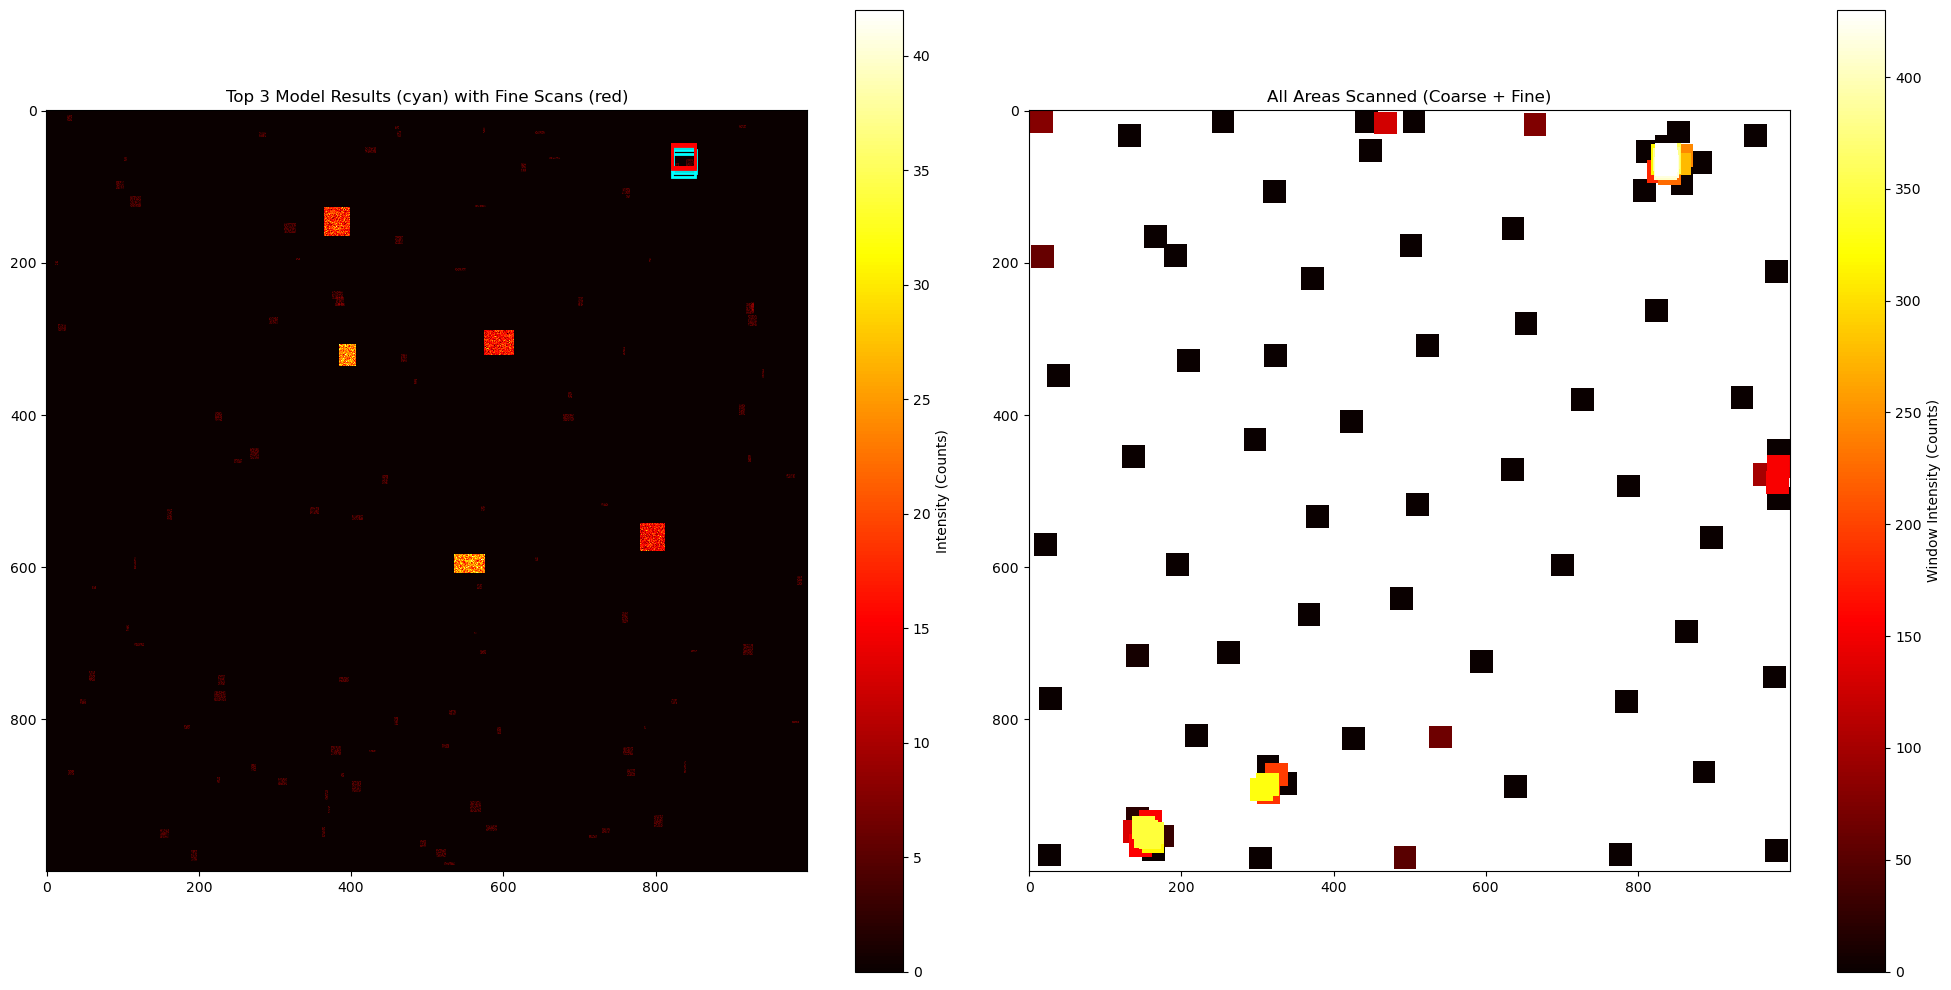

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

# -----------------------------
# 0. Set random seed for reproducibility
# -----------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# -----------------------------
# 1. Generate synthetic 1000x1000 data
# -----------------------------
grid_size = 1000
grid = np.zeros((grid_size, grid_size), dtype=int)  # empty background

# Add many tiny visible blobs randomly
num_tiny_blobs = 100
for _ in range(num_tiny_blobs):
    w, h = np.random.randint(3, 16), np.random.randint(3, 16)  # size 3-15
    x, y = np.random.randint(0, grid_size-w), np.random.randint(0, grid_size-h)
    grid[x:x+w, y:y+h] += np.random.randint(1, 6, size=(w,h))  # low intensity

# Add ~5 larger interesting blobs
blobs = []
for _ in range(5):
    x, y = np.random.randint(100, grid_size-100), np.random.randint(100, grid_size-100)
    w, h = np.random.randint(20, 50), np.random.randint(20, 50)
    grid[x:x+w, y:y+h] += np.random.poisson(lam=np.random.randint(15,25), size=(w,h))
    blobs.append(((x, y), w, h))

# -----------------------------
# 2. Objective function
# -----------------------------
window_size = 30
def hotspot_score(i, j, window_size=30):
    i, j = int(i), int(j)
    if i < 0 or j < 0 or i+window_size > grid_size or j+window_size > grid_size:
        return -1e6
    return grid[i:i+window_size, j:j+window_size].sum()

# -----------------------------
# 3. Bayesian Optimization
# -----------------------------
pbounds = {"i": (0, grid_size-window_size), "j": (0, grid_size-window_size)}

optimizer = BayesianOptimization(
    f=lambda i,j: hotspot_score(i, j, window_size=window_size),
    pbounds=pbounds,
    random_state=RANDOM_SEED,
    verbose=2
)

optimizer.maximize(init_points=10, n_iter=90)

# -----------------------------
# 4. Fine scan function
# -----------------------------
def fine_scan(center_i, center_j, window_size=30, scan_radius=10):
    best_score = -np.inf
    best_coords = None
    for di in range(-scan_radius, scan_radius+1):
        for dj in range(-scan_radius, scan_radius+1):
            i, j = center_i+di, center_j+dj
            if 0 <= i <= grid_size-window_size and 0 <= j <= grid_size-window_size:
                score = hotspot_score(i, j, window_size)
                if score > best_score:
                    best_score = score
                    best_coords = (i, j)
    return best_coords, best_score

# -----------------------------
# 5. Report top-3 results + fine scan
# -----------------------------
sorted_res = sorted(optimizer.res, key=lambda r: -r["target"])
top3 = sorted_res[:3]

print("\n=== Model Top 3 Results ===")
fine_results = []
for idx, res in enumerate(top3, 1):
    i, j = int(res["params"]["i"]), int(res["params"]["j"])
    score = res["target"]
    print(f"#{idx}: Coarse scan at ({i},{j}), score={score:.2f}")
    fine_coords, fine_score = fine_scan(i, j, window_size=window_size)
    print(f"   → Fine scan best at {fine_coords}, score={fine_score:.2f}")
    fine_results.append((fine_coords, fine_score))

# -----------------------------
# 6. Print ground truth top-5 blobs
# -----------------------------
intensities = []
for (x, y), w, h in blobs:
    intensity = grid[x:x+w, y:y+h].sum()
    intensities.append(((x,y), w,h,intensity))

top5_truth = sorted(intensities, key=lambda x: -x[3])[:5]

print("\n=== Ground Truth Top 5 Blobs ===")
for (x,y), w,h,intensity in top5_truth:
    print(f"Blob at ({x},{y}), size=({w}x{h}), intensity={intensity}")

# -----------------------------
# 7. Visualization side-by-side
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# First plot: full grid with top3 + fine scans
ax = axes[0]
im = ax.imshow(grid, cmap="hot", interpolation="nearest")

# Cyan boxes = coarse top-3
for res in top3:
    i, j = int(res["params"]["i"]), int(res["params"]["j"])
    rect = plt.Rectangle((j, i), window_size, window_size, 
                         edgecolor="cyan", facecolor="none", linewidth=2)
    ax.add_patch(rect)

# Red boxes = fine scans
for (coords, _) in fine_results:
    i, j = coords
    rect = plt.Rectangle((j, i), window_size, window_size, 
                         edgecolor="red", facecolor="none", linewidth=2)
    ax.add_patch(rect)

ax.set_title("Top 3 Model Results (cyan) with Fine Scans (red)")
plt.colorbar(im, ax=ax, label="Intensity (Counts)")

# Second plot: all scanned areas (coarse + fine)
ax2 = axes[1]
scan_grid = np.full_like(grid, np.nan, dtype=float)

# Fill scanned windows
for res in optimizer.res:
    i, j = int(res["params"]["i"]), int(res["params"]["j"])
    score = res["target"]
    scan_grid[i:i+window_size, j:j+window_size] = np.fmax(
        scan_grid[i:i+window_size, j:j+window_size], score
    )

# Include fine scans
for (coords, fine_score) in fine_results:
    i, j = coords
    scan_grid[i:i+window_size, j:j+window_size] = np.fmax(
        scan_grid[i:i+window_size, j:j+window_size], fine_score
    )

im2 = ax2.imshow(scan_grid, cmap="hot", interpolation="nearest")
ax2.set_title("All Areas Scanned (Coarse + Fine)")
plt.colorbar(im2, ax=ax2, label="Window Intensity (Counts)")

plt.tight_layout()
plt.show()


| iter     | target     | i          | j          |
--------------------------------------------------
| 1        | 0.0000     | 918.01074  | 838.40852  |
| 2        | 0.0000     | 21.65897   | 758.66777  |
| 3        | 0.0000     | 616.82020  | 480.50811  |
| 4        | 0.0000     | 584.55545  | 657.90256  |
| 5        | 305.0000   | 857.92375  | 744.33693  |
| 6        | 4460.0000  | 558.11648  | 799.87719  |
| 7        | 0.0000     | 957.31527  | 291.17656  |
| 8        | 0.0000     | 114.86807  | 709.50481  |
| 9        | 0.0000     | 949.23844  | 113.20474  |
| 10       | 0.0000     | 418.75604  | 60.39961   |
| 11       | 0.0000     | 753.23598  | 920.24745  |
| 12       | 0.0000     | 484.02433  | 397.23551  |
| 13       | 0.0000     | 880.48745  | 129.38674  |
| 14       | 361.0000   | 864.83678  | 380.36222  |
| 15       | 0.0000     | 542.62422  | 512.44334  |
| 16       | 0.0000     | 597.49980  | 913.85961  |
| 17       | 212.0000   | 922.59322  | 806.21382  |
| 18       | 

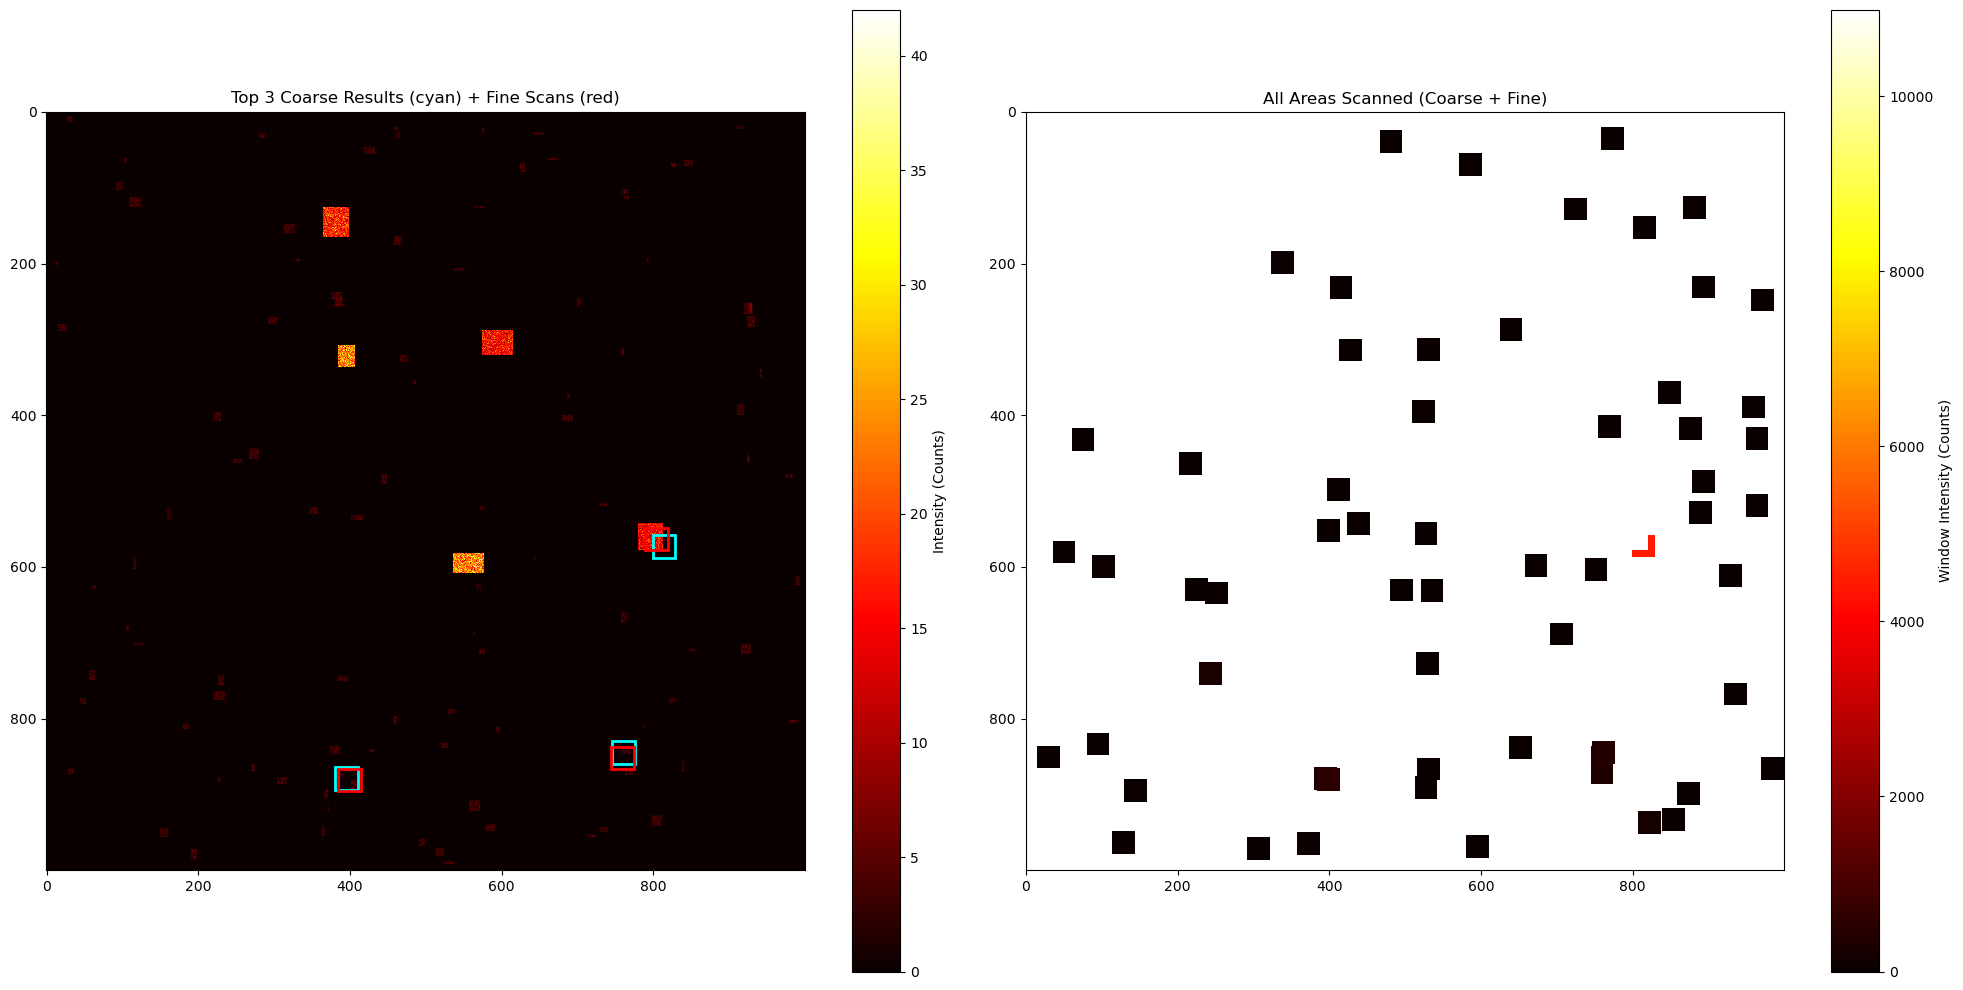

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0. Random seed for reproducibility
# -----------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# -----------------------------
# 1. Generate synthetic 1000x1000 data
# -----------------------------
grid_size = 1000
grid = np.zeros((grid_size, grid_size), dtype=int)  # empty background

# Add many tiny visible blobs
num_tiny_blobs = 100
for _ in range(num_tiny_blobs):
    w, h = np.random.randint(3, 16), np.random.randint(3, 16)
    x, y = np.random.randint(0, grid_size-w), np.random.randint(0, grid_size-h)
    grid[x:x+w, y:y+h] += np.random.randint(1, 6, size=(w,h))

# Add 5 larger interesting blobs
blobs = []
for _ in range(5):
    x, y = np.random.randint(100, grid_size-100), np.random.randint(100, grid_size-100)
    w, h = np.random.randint(20, 50), np.random.randint(20, 50)
    grid[x:x+w, y:y+h] += np.random.poisson(lam=np.random.randint(15,25), size=(w,h))
    blobs.append(((x, y), w, h))

# -----------------------------
# 2. Objective function
# -----------------------------
window_size = 30
def hotspot_score(i, j):
    i, j = int(i), int(j)
    if i < 0 or j < 0 or i+window_size > grid_size or j+window_size > grid_size:
        return -1e6
    return grid[i:i+window_size, j:j+window_size].sum()

# -----------------------------
# 3. Fine scan function
# -----------------------------
def fine_scan(center_i, center_j, scan_radius=10):
    best_score = -np.inf
    best_coords = None
    for di in range(-scan_radius, scan_radius+1):
        for dj in range(-scan_radius, scan_radius+1):
            i, j = center_i+di, center_j+dj
            if 0 <= i <= grid_size-window_size and 0 <= j <= grid_size-window_size:
                score = hotspot_score(i, j)
                if score > best_score:
                    best_score = score
                    best_coords = (i, j)
    return best_coords, best_score

# -----------------------------
# 4. Dynamic scan with IQR stopping, formatted printing
# -----------------------------
window_scores = []
scanned_coords = []
max_iterations = 500
stop_scan = False
iteration = 0
min_scans = 50
extra_scans_after_outlier = 10
outlier_found = False
extra_scan_counter = 0

print(f"| {'iter':<8} | {'target':<10} | {'i':<10} | {'j':<10} |")
print("-"*50)

while not stop_scan and iteration < max_iterations:
    i = np.random.uniform(0, grid_size-window_size)
    j = np.random.uniform(0, grid_size-window_size)
    score = hotspot_score(int(i), int(j))

    window_scores.append(score)
    scanned_coords.append((int(i), int(j)))
    iteration += 1

    # Determine if this is the highest score so far
    if score == max(window_scores):
        print(f"\033[95m| {iteration:<8} | {score:<10.4f} | {i:<10.5f} | {j:<10.5f} |\033[0m")
    else:
        print(f"| {iteration:<8} | {score:<10.4f} | {i:<10.5f} | {j:<10.5f} |")

    # Compute dynamic IQR from all scanned windows
    if len(window_scores) >= 10:
        Q1 = np.percentile(window_scores, 25)
        Q3 = np.percentile(window_scores, 75)
        IQR = Q3 - Q1
        threshold = Q3 + 1.5 * IQR

        if not outlier_found and iteration >= min_scans and score > threshold:
            print(f"*** Outlier detected at iteration {iteration} ({i:.5f},{j:.5f}) → scanning {extra_scans_after_outlier} more times ***")
            outlier_found = True
            extra_scan_counter = 0

    if outlier_found:
        extra_scan_counter += 1
        if extra_scan_counter >= extra_scans_after_outlier:
            stop_scan = True

# -----------------------------
# 5. Print final Q3/IQR from all scanned windows
# -----------------------------
if len(window_scores) >= 10:
    Q1 = np.percentile(window_scores, 25)
    Q3 = np.percentile(window_scores, 75)
    IQR = Q3 - Q1
    print(window_scores)
    print(f"\nFinal Q3: {Q3:.4f}, IQR: {IQR:.4f}")
else:
    print("\nNot enough scans to compute IQR")

# -----------------------------
# 6. Select top-3 coarse results
# -----------------------------
top3_indices = np.argsort(window_scores)[-3:][::-1]
top3 = [scanned_coords[idx] for idx in top3_indices]
top3_scores = [window_scores[idx] for idx in top3_indices]

print("\n=== Top 3 Coarse Scan Results ===")
fine_results = []
for idx, (i,j) in enumerate(top3):
    score = hotspot_score(i,j)
    print(f"#{idx+1}: Coarse scan at ({i},{j}), score={score:.2f}")
    fine_coords, fine_score = fine_scan(i,j)
    print(f"   → Fine scan best at {fine_coords}, score={fine_score:.2f}")
    fine_results.append((fine_coords, fine_score))

# -----------------------------
# 7. Print ground-truth top-5 blobs
# -----------------------------
intensities = []
for (x, y), w, h in blobs:
    intensity = grid[x:x+w, y:y+h].sum()
    intensities.append(((x,y), w,h,intensity))

top5_truth = sorted(intensities, key=lambda x: -x[3])[:5]
print("\n=== Ground Truth Top 5 Blobs ===")
for (x,y), w,h,intensity in top5_truth:
    print(f"Blob at ({x},{y}), size=({w}x{h}), intensity={intensity}")

# -----------------------------
# 8. Visualization side-by-side
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(20,10))

# First plot: full grid with top3 + fine scans
ax = axes[0]
im = ax.imshow(grid, cmap="hot", interpolation="nearest")

for (i,j) in top3:
    rect = plt.Rectangle((j, i), window_size, window_size,
                         edgecolor="cyan", facecolor="none", linewidth=2)
    ax.add_patch(rect)

for (coords, _) in fine_results:
    i, j = coords
    rect = plt.Rectangle((j, i), window_size, window_size,
                         edgecolor="red", facecolor="none", linewidth=2)
    ax.add_patch(rect)

ax.set_title("Top 3 Coarse Results (cyan) + Fine Scans (red)")
plt.colorbar(im, ax=ax, label="Intensity (Counts)")

# Second plot: all scanned areas
ax2 = axes[1]
scan_grid = np.full_like(grid, np.nan, dtype=float)
for (i,j), score in zip(scanned_coords, window_scores):
    scan_grid[i:i+window_size, j:j+window_size] = np.fmax(
        scan_grid[i:i+window_size, j:j+window_size], score
    )

for (coords, fine_score) in fine_results:
    i, j = coords
    scan_grid[i:i+window_size, j:j+window_size] = np.fmax(
        scan_grid[i:i+window_size, j:j+window_size], fine_score
    )

im2 = ax2.imshow(scan_grid, cmap="hot", interpolation="nearest")
ax2.set_title("All Areas Scanned (Coarse + Fine)")
plt.colorbar(im2, ax=ax2, label="Window Intensity (Counts)")

plt.tight_layout()
plt.show()


In [ ]:
#non bayesian
# total scan 

| iter     | target     | i          | j          |
--------------------------------------------------
| 5000     | 0.0000     | 5          | 144        |
| 10000    | 0.0000     | 10         | 289        |
| 15000    | 138.0000   | 15         | 434        |
| 20000    | 0.0000     | 20         | 579        |
| 25000    | 0.0000     | 25         | 724        |
| 30000    | 0.0000     | 30         | 869        |
| 35000    | 0.0000     | 36         | 43         |
| 40000    | 0.0000     | 41         | 188        |
| 45000    | 0.0000     | 46         | 333        |
| 50000    | 0.0000     | 51         | 478        |
| 55000    | 260.0000   | 56         | 623        |
| 60000    | 0.0000     | 61         | 768        |
| 65000    | 0.0000     | 66         | 913        |
| 70000    | 251.0000   | 72         | 87         |
| 75000    | 0.0000     | 77         | 232        |
| 80000    | 0.0000     | 82         | 377        |
| 85000    | 0.0000     | 87         | 522        |
| 90000    | 

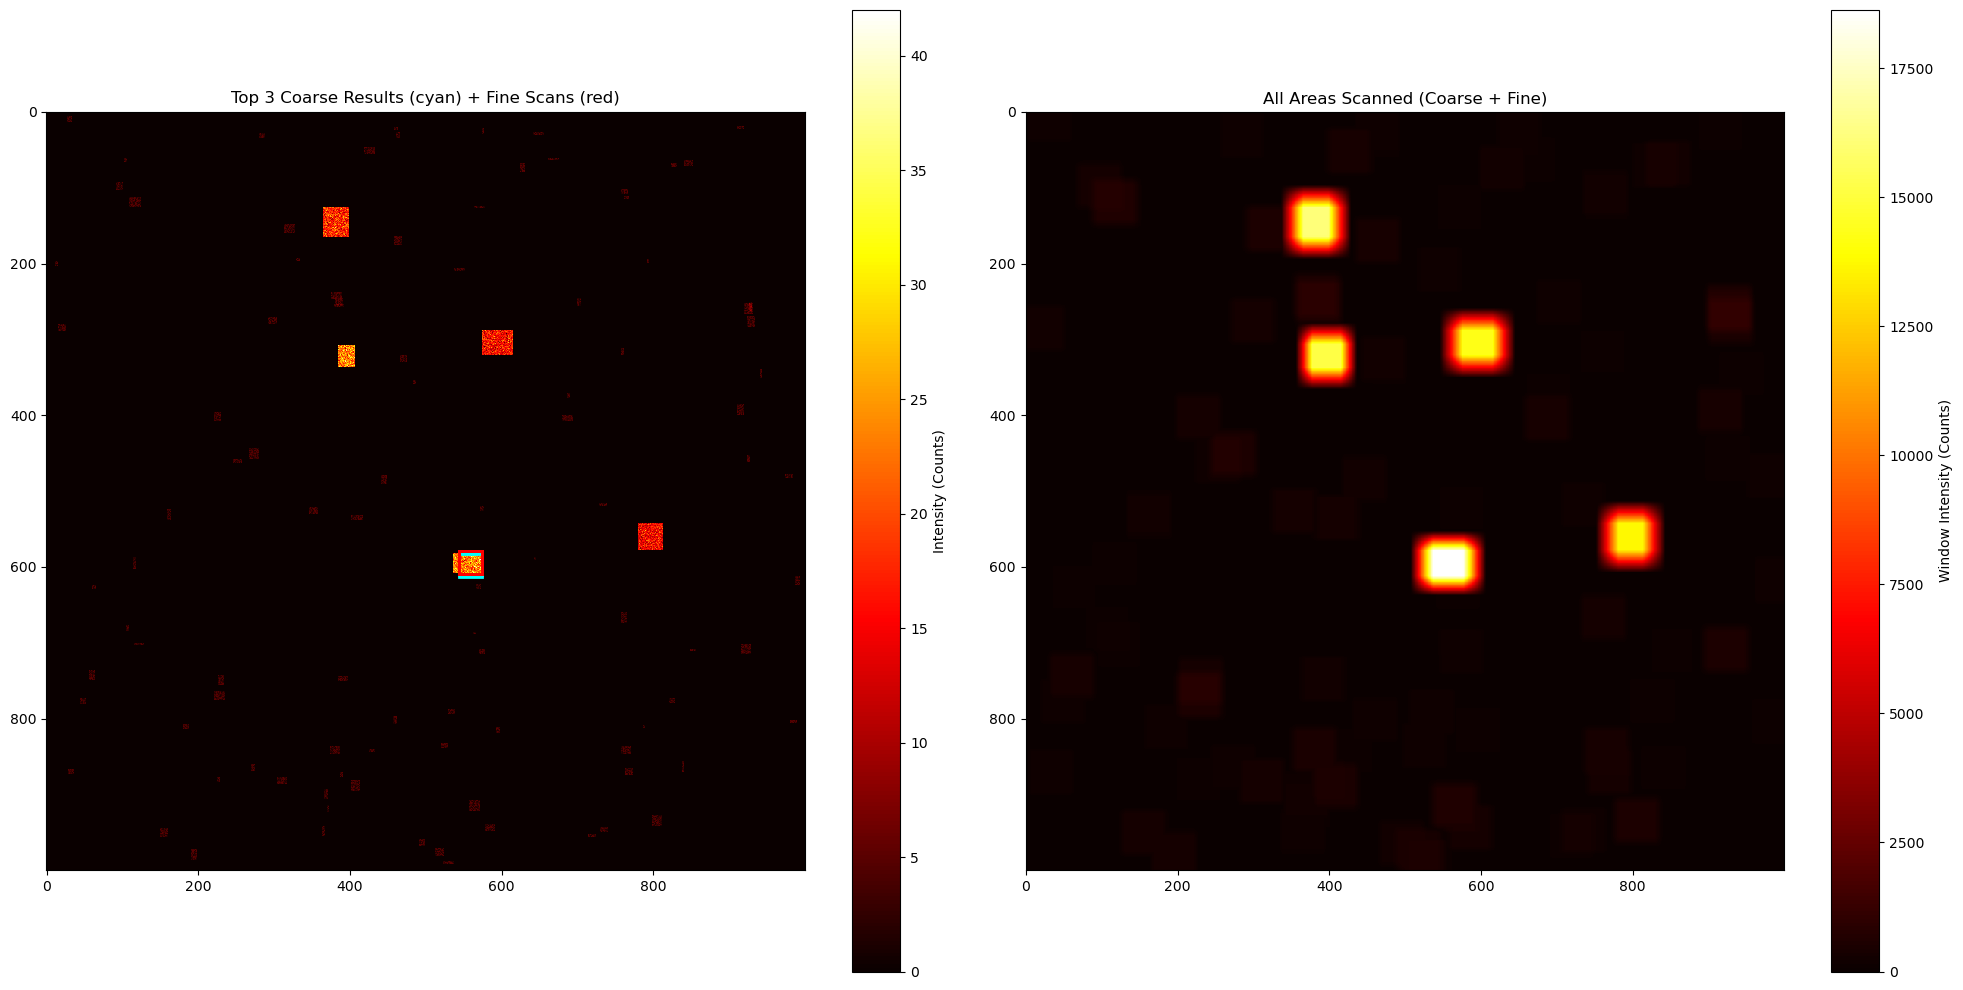

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import time

# -----------------------------
# 0. Random seed for reproducibility
# -----------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# -----------------------------
# 1. Generate synthetic 1000x1000 data
# -----------------------------
grid_size = 1000
grid = np.zeros((grid_size, grid_size), dtype=int)  # empty background

# Add many tiny visible blobs
num_tiny_blobs = 100
for _ in range(num_tiny_blobs):
    w, h = np.random.randint(3, 16), np.random.randint(3, 16)
    x, y = np.random.randint(0, grid_size-w), np.random.randint(0, grid_size-h)
    grid[x:x+w, y:y+h] += np.random.randint(1, 6, size=(w,h))

# Add 5 larger interesting blobs
blobs = []
for _ in range(5):
    x, y = np.random.randint(100, grid_size-100), np.random.randint(100, grid_size-100)
    w, h = np.random.randint(20, 50), np.random.randint(20, 50)
    grid[x:x+w, y:y+h] += np.random.poisson(lam=np.random.randint(15,25), size=(w,h))
    blobs.append(((x, y), w, h))

# -----------------------------
# 2. Objective function
# -----------------------------
window_size = 30
def hotspot_score(i, j):
    i, j = int(i), int(j)
    if i < 0 or j < 0 or i+window_size > grid_size or j+window_size > grid_size:
        return -1e6
    return grid[i:i+window_size, j:j+window_size].sum()

# -----------------------------
# 3. Fine scan function
# -----------------------------
def fine_scan(center_i, center_j, scan_radius=10):
    best_score = -np.inf
    best_coords = None
    for di in range(-scan_radius, scan_radius+1):
        for dj in range(-scan_radius, scan_radius+1):
            i, j = center_i+di, center_j+dj
            if 0 <= i <= grid_size-window_size and 0 <= j <= grid_size-window_size:
                score = hotspot_score(i, j)
                if score > best_score:
                    best_score = score
                    best_coords = (i, j)
    return best_coords, best_score

# -----------------------------
# 4. Full deterministic grid scan
# -----------------------------
window_scores = []
scanned_coords = []

iteration = 0
start_time = time.time()

print(f"| {'iter':<8} | {'target':<10} | {'i':<10} | {'j':<10} |")
print("-"*50)

for i in range(0, grid_size - window_size + 1):
    for j in range(0, grid_size - window_size + 1):
        score = hotspot_score(i, j)
        window_scores.append(score)
        scanned_coords.append((i, j))
        iteration += 1

        # Only print every 5000 scans
        if iteration % 5000 == 0:
            print(f"| {iteration:<8} | {score:<10.4f} | {i:<10} | {j:<10} |")

end_time = time.time()
print(f"\nTotal scans: {iteration}, Time elapsed: {end_time - start_time:.2f} seconds")

# -----------------------------
# 5. Compute final IQR from non-zero scores
# -----------------------------
non_zero_scores = [s for s in window_scores if s > 0]
if len(non_zero_scores) >= 10:
    Q1 = np.percentile(non_zero_scores, 25)
    Q3 = np.percentile(non_zero_scores, 75)
    IQR = Q3 - Q1
    print(f"Final Q3: {Q3:.4f}, IQR: {IQR:.4f}")
else:
    print("Not enough non-zero scans to compute IQR")

# -----------------------------
# 6. Select top-3 coarse results
# -----------------------------
top3_indices = np.argsort(window_scores)[-3:][::-1]
top3 = [scanned_coords[idx] for idx in top3_indices]
top3_scores = [window_scores[idx] for idx in top3_indices]

print("\n=== Top 3 Coarse Scan Results ===")
fine_results = []
for idx, (i,j) in enumerate(top3):
    score = hotspot_score(i,j)
    print(f"#{idx+1}: Coarse scan at ({i},{j}), score={score:.2f}")
    fine_coords, fine_score = fine_scan(i,j)
    print(f"   → Fine scan best at {fine_coords}, score={fine_score:.2f}")
    fine_results.append((fine_coords, fine_score))

# -----------------------------
# 7. Print ground-truth top-5 blobs
# -----------------------------
intensities = []
for (x, y), w, h in blobs:
    intensity = grid[x:x+w, y:y+h].sum()
    intensities.append(((x,y), w,h,intensity))

top5_truth = sorted(intensities, key=lambda x: -x[3])[:5]
print("\n=== Ground Truth Top 5 Blobs ===")
for (x,y), w,h,intensity in top5_truth:
    print(f"Blob at ({x},{y}), size=({w}x{h}), intensity={intensity}")

# -----------------------------
# 8. Visualization side-by-side
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(20,10))

# First plot: full grid with top3 + fine scans
ax = axes[0]
im = ax.imshow(grid, cmap="hot", interpolation="nearest")

for (i,j) in top3:
    rect = plt.Rectangle((j, i), window_size, window_size,
                         edgecolor="cyan", facecolor="none", linewidth=2)
    ax.add_patch(rect)

for (coords, _) in fine_results:
    i, j = coords
    rect = plt.Rectangle((j, i), window_size, window_size,
                         edgecolor="red", facecolor="none", linewidth=2)
    ax.add_patch(rect)

ax.set_title("Top 3 Coarse Results (cyan) + Fine Scans (red)")
plt.colorbar(im, ax=ax, label="Intensity (Counts)")

# Second plot: all scanned areas
ax2 = axes[1]
scan_grid = np.full_like(grid, np.nan, dtype=float)
for (i,j), score in zip(scanned_coords, window_scores):
    scan_grid[i:i+window_size, j:j+window_size] = np.fmax(
        scan_grid[i:i+window_size, j:j+window_size], score
    )

for (coords, fine_score) in fine_results:
    i, j = coords
    scan_grid[i:i+window_size, j:j+window_size] = np.fmax(
        scan_grid[i:i+window_size, j:j+window_size], fine_score
    )

im2 = ax2.imshow(scan_grid, cmap="hot", interpolation="nearest")
ax2.set_title("All Areas Scanned (Coarse + Fine)")
plt.colorbar(im2, ax=ax2, label="Window Intensity (Counts)")

plt.tight_layout()
plt.show()
